# Part II: Training a model

Date: 23/08/2022

Authors: Jordi Bolibar & Facundo Sapienza

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Data Preparation

Since we have records of mass balance every 10 years, we will assign to each hydrological year in every period 2000-2010 and 2010-2020 the same part of mass balance that results from grabing the total mass balance in the 1o year period and divide it by 10. 

In [2]:
df_target = pd.read_csv('Data/mb_df.csv')

# Restrict to the two target peroids we have for training
df_target = df_target.replace({'2000-01-01_2010-01-01': '2000-2010',
                               '2010-01-01_2020-01-01': '2010-2020'})
df_target = df_target[df_target.period.isin(['2000-2010', '2010-2020'])]
# We add an unique id to each row to recognized repeited measurements 
df_target['target_id'] = np.arange(0, df_target.shape[0])

# Add hydro year of the target 
dfs = []
for i in range(10):
    df_ = df_target.copy()
    df_['hydro_year'] = np.select([(df_.period=='2000-2010'),
                                         (df_.period=='2010-2020')], 
                                         [2000+i, 2010+i])
    dfs.append(df_)

df_target = pd.concat(dfs, axis=0)
df_target = df_target.set_index(['rgi_id', 'hydro_year'])
df_target = df_target.sort_values(['rgi_id', 'hydro_year'])
df_target = df_target[['dmdtda', 'err_dmdtda', 'period','target_id']]
df_target

dmdtda  err_dmdtda     period  target_id
rgi_id         hydro_year                                            
RGI60-08.00001 2000       -0.458772     0.44912  2000-2010          0
               2001       -0.458772     0.44912  2000-2010          0
               2002       -0.458772     0.44912  2000-2010          0
               2003       -0.458772     0.44912  2000-2010          0
               2004       -0.458772     0.44912  2000-2010          0
...                             ...         ...        ...        ...
RGI60-08.03417 2015        0.389200     0.49660  2010-2020       6833
               2016        0.389200     0.49660  2010-2020       6833
               2017        0.389200     0.49660  2010-2020       6833
               2018        0.389200     0.49660  2010-2020       6833
               2019        0.389200     0.49660  2010-2020       6833

[68340 rows x 4 columns]

We now read the input data and merge it with the target response. 

In [3]:
df_features = pd.read_csv('Data/training_df.csv', index_col=['rgi_id', 'hydro_year'])
df_features

PDD          RGI_ID  area  icecap     lat  \
rgi_id         hydro_year                                                    
RGI60-08.00001 2000        40.322890  RGI60-08.00001  0.03       0  67.930   
               2001        42.489556  RGI60-08.00001  0.03       0  67.930   
               2002        38.044445  RGI60-08.00001  0.03       0  67.930   
               2003        39.844445  RGI60-08.00001  0.03       0  67.930   
               2004        40.577779  RGI60-08.00001  0.03       0  67.930   
...                              ...             ...   ...     ...     ...   
RGI60-08.03417 2015        51.437776  RGI60-08.03417  0.15       0  65.923   
               2016        55.643333  RGI60-08.03417  0.15       0  65.923   
               2017        50.003331  RGI60-08.03417  0.15       0  65.923   
               2018        57.004444  RGI60-08.03417  0.15       0  65.923   
               2019        54.643332  RGI60-08.03417  0.15       0  65.923   

                              prcp_01     prcp_02     prcp_03     prcp_04  \
rgi_id         hydro_year                                                   
RGI60-08.00001 2000         89.949440   39.799580   51.759113   50.980053   
               2001         50.515020   43.414460   49.670944   27.386324   
               2002         59.345170   29.263450   24.280972   44.494130   
               2003         48.070133   34.243984   27.780344   46.093716   
               2004         78.174040   31.993261   62.266920   28.106590   
...                               ...         ...         ...         ...   
RGI60-08.03417 2015        104.149030  111.409660  266.413970  155.734220   
               2016        217.098800  211.801880  242.586320  101.253310   
               2017         89.045910  149.197240  371.887760  299.347630   
               2018        176.113360  158.276730  192.674560   64.232956   
               2019        217.587550  137.044170  171.008670  167.764050   

                              prcp_05  ...    temp_06   temp_07   temp_08  \
rgi_id         hydro_year              ...                                  
RGI60-08.00001 2000         29.002270  ...  -6.611111 -1.732222  3.233333   
               2001         35.375156  ... -12.011110 -1.865555  1.533333   
               2002         44.540123  ...  -8.044444 -0.898889  3.333334   
               2003         26.073019  ...  -5.611111 -3.232222  4.133333   
               2004         40.665600  ...  -7.111110 -2.298889  3.033333   
...                               ...  ...        ...       ...       ...   
RGI60-08.03417 2015        189.870130  ...  -2.700000 -1.488889  2.322222   
               2016        108.876656  ...  -3.800000 -1.455556  4.088889   
               2017        121.731080  ...  -5.200000 -2.988889  1.355555   
               2018         24.806946  ...  -8.999999 -1.488889  5.588889   
               2019        227.375120  ...  -6.400000  0.211111  2.022222   

                             temp_09    temp_10    temp_11   temp_12    zmax  \
rgi_id         hydro_year                                                      
RGI60-08.00001 2000         9.202221  13.494446  10.450000  5.927779   250.0   
               2001        10.002221  13.594445  10.316667  7.627779   250.0   
               2002         9.202221  13.794446  10.316667  4.727778   250.0   
               2003         6.135554  15.094445  11.316667  6.494445   250.0   
               2004         8.102222  14.727779  11.216666  6.827778   250.0   
...                              ...        ...        ...       ...     ...   
RGI60-08.03417 2015         5.307778   8.482221  10.999999  6.890000  1318.0   
               2016         6.907778  10.382221   8.599999  7.290001  1318.0   
               2017         7.507778   9.482221   8.799999  6.890000  1318.0   
               2018         6.007778  12.582221   9.400000  5.990001  1318.0   
               2019         7.674444  10.182220   9.99

In [4]:
df_all = df_features.merge(df_target, 
                           left_on=['rgi_id','hydro_year'], 
                           right_on=['rgi_id','hydro_year'])
df_all

PDD          RGI_ID  area  icecap     lat  \
rgi_id         hydro_year                                                    
RGI60-08.00001 2000        40.322890  RGI60-08.00001  0.03       0  67.930   
               2001        42.489556  RGI60-08.00001  0.03       0  67.930   
               2002        38.044445  RGI60-08.00001  0.03       0  67.930   
               2003        39.844445  RGI60-08.00001  0.03       0  67.930   
               2004        40.577779  RGI60-08.00001  0.03       0  67.930   
...                              ...             ...   ...     ...     ...   
RGI60-08.03417 2015        51.437776  RGI60-08.03417  0.15       0  65.923   
               2016        55.643333  RGI60-08.03417  0.15       0  65.923   
               2017        50.003331  RGI60-08.03417  0.15       0  65.923   
               2018        57.004444  RGI60-08.03417  0.15       0  65.923   
               2019        54.643332  RGI60-08.03417  0.15       0  65.923   

                              prcp_01     prcp_02     prcp_03     prcp_04  \
rgi_id         hydro_year                                                   
RGI60-08.00001 2000         89.949440   39.799580   51.759113   50.980053   
               2001         50.515020   43.414460   49.670944   27.386324   
               2002         59.345170   29.263450   24.280972   44.494130   
               2003         48.070133   34.243984   27.780344   46.093716   
               2004         78.174040   31.993261   62.266920   28.106590   
...                               ...         ...         ...         ...   
RGI60-08.03417 2015        104.149030  111.409660  266.413970  155.734220   
               2016        217.098800  211.801880  242.586320  101.253310   
               2017         89.045910  149.197240  371.887760  299.347630   
               2018        176.113360  158.276730  192.674560   64.232956   
               2019        217.587550  137.044170  171.008670  167.764050   

                              prcp_05  ...    temp_10    temp_11   temp_12  \
rgi_id         hydro_year              ...                                   
RGI60-08.00001 2000         29.002270  ...  13.494446  10.450000  5.927779   
               2001         35.375156  ...  13.594445  10.316667  7.627779   
               2002         44.540123  ...  13.794446  10.316667  4.727778   
               2003         26.073019  ...  15.094445  11.316667  6.494445   
               2004         40.665600  ...  14.727779  11.216666  6.827778   
...                               ...  ...        ...        ...       ...   
RGI60-08.03417 2015        189.870130  ...   8.482221  10.999999  6.890000   
               2016        108.876656  ...  10.382221   8.599999  7.290001   
               2017        121.731080  ...   9.482221   8.799999  6.890000   
               2018         24.806946  ...  12.582221   9.400000  5.990001   
               2019        227.375120  ...  10.182220   9.999999  4.990001   

                             zmax    zmed    zmin    dmdtda  err_dmdtda  \
rgi_id         hydro_year                                                 
RGI60-08.00001 2000         250.0   242.0   235.0 -0.458772     0.44912   
               2001         250.0   242.0   235.0 -0.458772     0.44912   
               2002         250.0   242.0   235.0 -0.458772     0.44912   
               2003         250.0   242.0   235.0 -0.458772     0.44912   
               2004         250.0   242.0   235.0 -0.458772     0.44912   
...                           ...     ...     ...       ...         ...   
RGI60-08.03417 2015        1318.0  1186.0  1090.0  0.389200     0.49660   
               2016        1318.0  1186.0  1090.0  0.389200     0.49660   
               2017        1318.0  1186.0  1090.0  0.389200     0.49660   
               2018        1318.0  1186.0  1090.0  0.389200     0.49660   
               2019        1318.0  1186.0  1090.0  0.389200     0.49660   

                         

## Setup

At this point, `df_all` has all the data we will need to train, validate and test the model. However, before moving forward to training a machine learning model with this data, we need to separate an part of the dataset for testing the model and be sure we are not overfitting the model. 

For testing, we can use different strategies:
1. Separate all the measurements for some given set of glaciers and use all the rest for training/validation
1. Separate all the measurements for some given set of glaciers at period (2010-2020) and use all the rest for trainign/validation
1. Separate all the measurements for some given set of glaciers at the period 2010-2020 and use all the measurements for rest of the glaciers and the other period 2000-2010 for training/validation.

For simplicity, in this notebook we are going to implement the first one, but this may not be necessaraly the best option (why?). 

In [5]:
# We select a subset of glaciers and use them for test and the rest for training
glaciers_ids = np.unique(df_all.index.get_level_values(0).values)

glacier_train, glacier_test = train_test_split(glaciers_ids, 
                                               train_size=0.8,
                                               test_size=0.2)

df_train = df_all.loc[glacier_train]
df_test = df_all.loc[glacier_test]
df_train.shape, df_test.shape

((54660, 39), (13680, 39))

In [6]:
df_train_X = df_train.drop(['RGI_ID', 'dmdtda', 'err_dmdtda', 'period', 'target_id'], axis=1)
df_train_y = df_train[['dmdtda']]

X_train, y_train = df_train_X.values, df_train_y.values

# And the same for test set
df_test_X = df_test.drop(['RGI_ID', 'dmdtda', 'err_dmdtda', 'period', 'target_id'], axis=1)
df_test_y = df_test[['dmdtda']]

X_test, y_test = df_test_X.values, df_test_y.values

## Data Exploration

array([[<AxesSubplot:title={'center':'dmdtda'}>]], dtype=object)

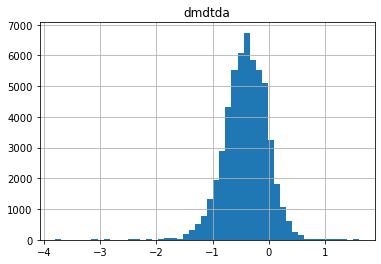

In [225]:
df_train_y.hist(bins=50)

## Training a model 

The `sklearn` package includes multiple regression models we can try on the dataset. One of the advantages of using `sklearn` is that the syntax and logic is shared among different algorithms, making easy to try and compare different models. The [sklearn documentation](https://scikit-learn.org/stable/auto_examples/index.html#examples) includes multiple of these examples that are worth exploring. 

Some regression methods to explore include
1. Clasical continouos regression approaches: linear regression, logistic regression, support vector machines
1. Tree-based regression: decision trees, random forest, ensamble methods based on boosting
1. Neural networks

The following plot function will be useful in order to report the performance of the different models.

In [130]:
def plot_prediction(y1, y2, n_toplot=10**10):
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    plt.figure(figsize=(8,8))
    plt.title("Model Evaluation", fontsize=17)
    plt.ylabel('Modeled SMB (m.w.e)', fontsize=16)
    plt.xlabel('Reference SMB (m.w.e)', fontsize=16)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=50)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    plt.colorbar(sc) 
    lineStart = -2
    lineEnd = 2
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.show()

### Linear Regression

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

For linear regression and many other methods, we will scale the data to have zero mean and unit variance.

In [133]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [136]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

ElasticNet is a linear regression model that includes the classical ordinary least square error estimatior (`alpha=0.0`), Lasso (`l1_ratio=1`) and Ridge (`l1_ratio=0`) regression in one single method. 

In [213]:
%time
reg_linear = ElasticNet(alpha=0.001,
                        l1_ratio=0.8,
                        fit_intercept=True, 
                        random_state=666)
reg_linear.fit(X_train_scaled, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


ElasticNet(alpha=0.001, l1_ratio=0.8, random_state=666)

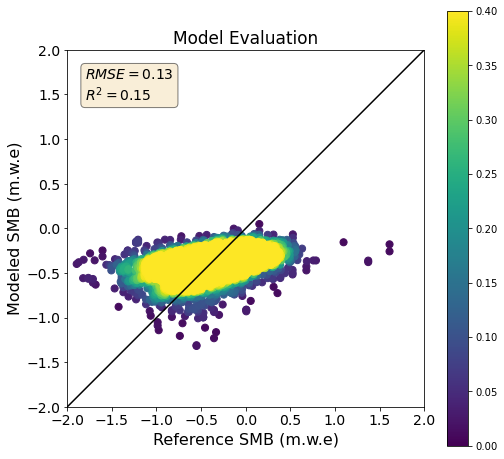

In [214]:
plot_prediction(y_train, reg_linear.predict(X_train_scaled), n_toplot=5000)

### Decision Tree Regressor

In [110]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [226]:
%%time
reg_tree = DecisionTreeRegressor(random_state=0, 
                                 max_depth=5, 
                                 min_samples_split=5)
reg_tree.fit(X_train, y_train)

CPU times: user 603 ms, sys: 7.62 ms, total: 610 ms
Wall time: 609 ms


DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=0)

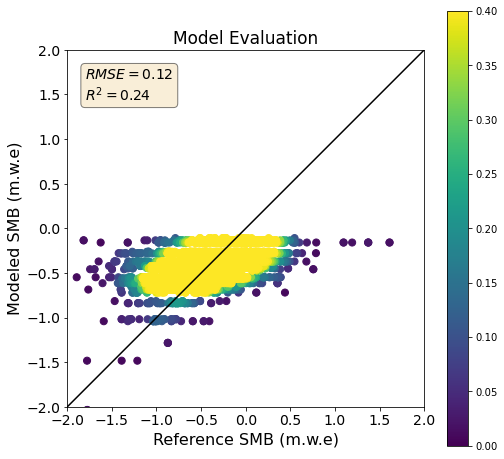

In [227]:
plot_prediction(y_train, reg_tree.predict(X_train), n_toplot=5000)

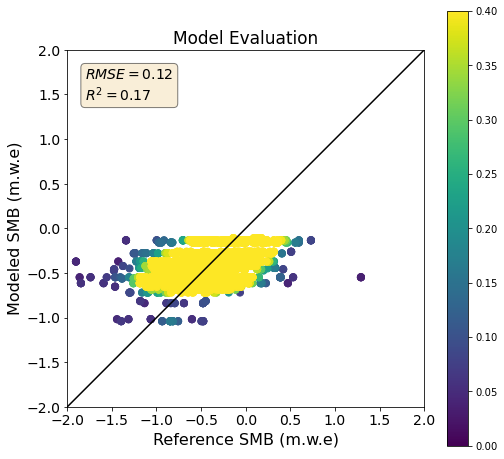

In [228]:
plot_prediction(y_test, reg_tree.predict(X_test), n_toplot=5000)

How well does this behave in test set?

### Ensamble of trees

We can try examples of models that combine slow learners. This models tend to work very well and be quite general. However, tunning the different hyper-parameters of the model can be tricky and something that will be explore in deeper detail in the next notebook. 

Example based on [Gradient boosting regression](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py)

In [114]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance

In [229]:
#model = 'random forest'
model = 'gradient boosting'

if model == 'gradient boosting':

    params = {
        "n_estimators": 300,
        "max_depth": 6,
        "min_samples_split": 5,
        "learning_rate": 0.1,
        "loss": "squared_error",
        "validation_fraction": 0.2
    }
    reg_ensemble = ensemble.GradientBoostingRegressor(**params)
    
elif model == 'random forest':
    
    params = {
        "n_estimators": 100,
        "max_depth": 4,
        "min_samples_split": 15,
        "criterion": "squared_error",
        'max_features': 10,
    }
    reg_ensemble = ensemble.RandomForestRegressor(**params)

In [230]:
%%time
reg_ensemble.fit(X_train, y_train)

/home/jovyan/.conda/envs/MB_Finsen/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3min 26s, sys: 6.84 ms, total: 3min 26s
Wall time: 3min 26s


GradientBoostingRegressor(max_depth=6, min_samples_split=5, n_estimators=300,
                          validation_fraction=0.2)

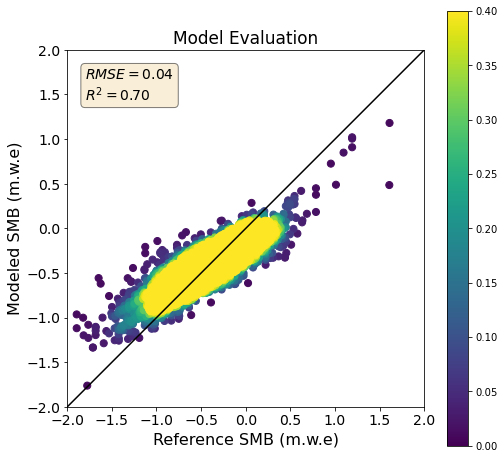

In [231]:
plot_prediction(y_train, reg_ensemble.predict(X_train), n_toplot=5000)

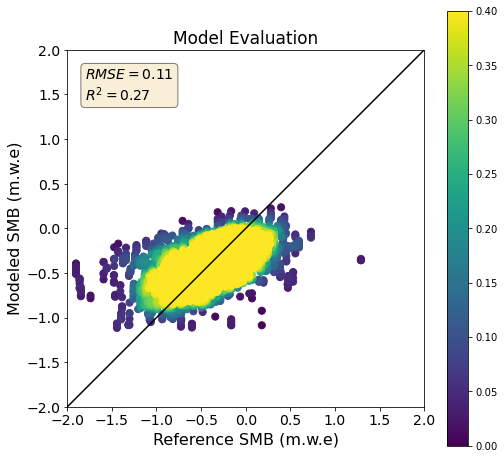

In [232]:
plot_prediction(y_test, reg_ensemble.predict(X_test), n_toplot=5000)

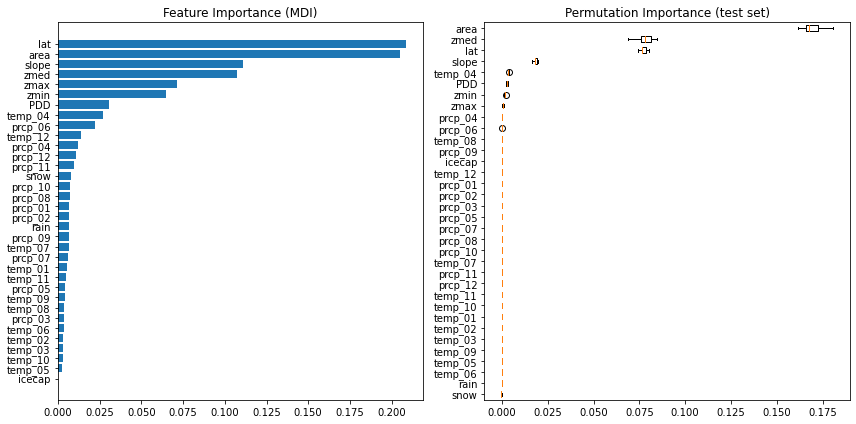

In [233]:
feature_importance = reg_ensemble.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df_train_X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### Neural Network

In [235]:
df_train_X.columns

Index(['PDD', 'area', 'icecap', 'lat', 'prcp_01', 'prcp_02', 'prcp_03',
       'prcp_04', 'prcp_05', 'prcp_06', 'prcp_07', 'prcp_08', 'prcp_09',
       'prcp_10', 'prcp_11', 'prcp_12', 'rain', 'slope', 'snow', 'temp_01',
       'temp_02', 'temp_03', 'temp_04', 'temp_05', 'temp_06', 'temp_07',
       'temp_08', 'temp_09', 'temp_10', 'temp_11', 'temp_12', 'zmax', 'zmed',
       'zmin'],
      dtype='object')

In [236]:
df_features.columns

Index(['PDD', 'RGI_ID', 'area', 'icecap', 'lat', 'prcp_01', 'prcp_02',
       'prcp_03', 'prcp_04', 'prcp_05', 'prcp_06', 'prcp_07', 'prcp_08',
       'prcp_09', 'prcp_10', 'prcp_11', 'prcp_12', 'rain', 'slope', 'snow',
       'temp_01', 'temp_02', 'temp_03', 'temp_04', 'temp_05', 'temp_06',
       'temp_07', 'temp_08', 'temp_09', 'temp_10', 'temp_11', 'temp_12',
       'zmax', 'zmed', 'zmin'],
      dtype='object')